<a href="https://colab.research.google.com/github/AudreyNessa/Stock-Market-Prediction/blob/main/stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/axis-bank/AXISBANK.NS (1).csv
/kaggle/input/india-headlines-news-dataset/india-news-headlines.csv


In [ ]:
!pip install openai
#more libraries
import json
import matplotlib.pyplot as plt
import openai
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import time
from xgboost import XGBRegressor

#set the api key for open ai
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("openaikey")
openai.api_key = OPENAI_API_KEY

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    """
    Returns answers to the prompt
    """
    messages = [{"role": "user", "content":prompt}]
    response = openai.ChatCompletion.create(
        model = model,
        messages = messages,
        temperature = 0
    )
    return response.choices[0].message["content"]

In [ ]:
#read the datasets
news = pd.read_csv("/kaggle/input/india-headlines-news-dataset/india-news-headlines.csv")
stock_prices = pd.read_csv("/kaggle/input/axis-bank/AXISBANK.NS (1).csv")

print(f"News Dataset \n{news}\n")
print(f"Stock prices \n{stock_prices}")

News Dataset 
         publish_date              headline_category  \
0            20010102                        unknown   
1            20010102                        unknown   
2            20010102                        unknown   
3            20010102                        unknown   
4            20010102                        unknown   
...               ...                            ...   
3650965      20220331                  city.srinagar   
3650966      20220331  entertainment.hindi.bollywood   
3650967      20220331                    city.trichy   
3650968      20220331                     city.erode   
3650969      20220331                     city.salem   

                                             headline_text  
0        Status quo will not be disturbed at Ayodhya; s...  
1                      Fissures in Hurriyat over Pak visit  
2                    America's unwanted heading for India?  
3                       For bigwigs; it is destination Goa  
4       

In [ ]:
#make the date columns the indices of the datasets
news["publish_date"] = pd.to_datetime(news["publish_date"], format="%Y%m%d")
news = news.set_index("publish_date").to_period('M')

stock_prices["Date"] = pd.to_datetime(stock_prices["Date"], format="%Y-%m-%d")
stock_prices = stock_prices.set_index("Date").to_period('D')


# Numerical Analysis

In [ ]:
#function definitions
def plot_periodogram(ts, detrend="linear", ax=None):
    """
    Plots a periodogram to know how many fourier pairs to include in our feature set
    """
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend, 
        window="boxcar",
        scaling="spectrum"
    )
    
    if ax is None:
        _, ax = plt.subplots()
        ax.step(frequencies, spectrum, color="red") 
        ax.set_xscale("log")
        ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
        ax.set_xticklabels([
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)", 
            "Bimonthly (6)", 
            "Monthly (12)", 
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)"
        ], rotation=30)
        ax.set_ylabel("Variance")
        ax.set_title("Periodogram")
        return ax

In [ ]:
#make stock prices dataset have the same starting date with the news dataset
y = stock_prices.loc["2001-01-01":]["Adj Close"]
y.columns = ["Prices"]
y = y.squeeze() #change from dataframe to series

****Clean and Preprocess Data****

In [ ]:
print(f"Sum of missing values in stock prices in the training set\n{y.isna().sum()}\n")

Sum of missing values in stock prices in the training set
10



In [ ]:
#drop missing values
y = y.dropna()

****Identify the Trend and Seasonality****

Text(0.5, 1.0, 'Stock Prices')

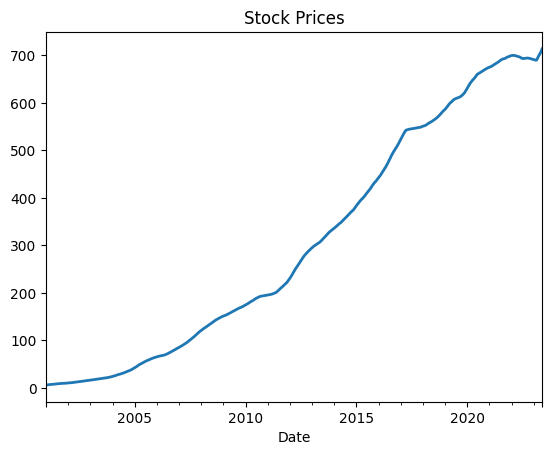

In [ ]:
#compute a moving average for trend estimation
moving_average = y.rolling(
    window=1460,
    center=True, #puts the average at the centre of the window
    min_periods= 730 #choose about half of the window size
).mean()

#plot the values
ax = moving_average.plot(linewidth=2)
ax.set_title("Stock Prices")

/tmp/ipykernel_20/4245826264.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

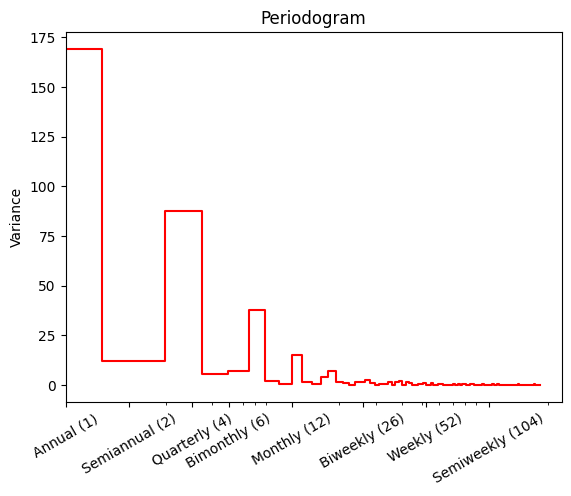

In [ ]:
#check for a year's seasonality 
plot_periodogram(y.loc["2012"])


**Create Features Based on the Information**

In [ ]:
fourier = CalendarFourier(freq="A", order=12)
#make features
dp = DeterministicProcess(
    index=y.index, #dates from the training data
    order=2, #the time dummy (trend)
    seasonal=True,
    additional_terms=[fourier],
    drop=True #drop terms if necessary to avoid colinearity
)

#create a feature set for the dates given in y_train index
X = dp.in_sample()

# Sentiment Analysis

In [ ]:
#get the news that contains information on Axis bank or UTI bank(previous name)
Axis_bool = news["headline_text"].str.contains('|'.join(["Axis bank", "uti bank"]), case=False)
Axis_news = news[Axis_bool]["headline_text"]
Axis_news

publish_date
2001-04                 GTB; UTI Bank end mega-merger dreams
2001-09            UTI Bank signs MoU with postal department
2001-09           UTI Bank earns Rs 158 cr via pvt placement
2001-12                             UTI bank ATM inaugurated
2001-12             FFIs to acquire 26.01% stake in UTI Bank
                                 ...                        
2021-09    Axis Bank diversity charter to empower staff; ...
2021-09    Future Generali CEO Munish Sharda to head Axis...
2021-10                RBI nod for Axis Bank CEO's extension
2021-12    Don't see need to extend deadline for Covid-hi...
2021-12          Axis Bank is second largest in PoS machines
Freq: M, Name: headline_text, Length: 220, dtype: object

In [ ]:
#convert the dataframe to a list and conduct a sentiment analysis in batches using ChatGPT
#the free version only allows 3 requests per minute
Axis_news_list = list(Axis_news)
Axis_news_list = [item.replace("'", '"') for item in Axis_news_list] #replace double quotes with single
Axis_news_list = [item.replace('"','') for item in Axis_news_list] #remove double quotes from the list
Axis_news_length = len(Axis_news) + 1
start = 0
response = ""

for stop in range(20, Axis_news_length, 20):
    batch = list(Axis_news_list[start:stop])
    prompt = f"""
    Find the sentiment for each sentence in the python list delimited with triple backticks.
    Let your answer be in the form of a python list with a length of 20,
    where each rating corresponds to each sentence in the list delimited with triple backticks.
    Denote negative as -1, positive as 1, and neutral as 0
    Take your time to find the sentiment of each sentence before giving an answer.
    Let the list contain only the sentiment ratings.
    ```{batch}```
    """
    response = response + get_completion(prompt)
    start = stop
    time.sleep(20) 
response

'[0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 1][1, 0, 1, 1, 1, 0, -1, 1, 0, -1, -1, 1, -1, -1, 0, 0, 1, 1, 0, -1][0, -1, 1, 0, 1, 0, 1, 1, 1, 0, -1, -1, 0, 1, 1, 1, -1, 1, -1, 1][0, 1, 1, -1, 1, 0, 0, -1, 0, 1, 0, -1, -1, 1, -1, -1, 1, 1, 1, -1][1, -1, -1, 1, -1, 1, 1, 1, 0, 0, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1][0, 1, 1, 0, -1, -1, -1, -1, -1, 1, 0, 1, 0, 0, 1, -1, -1, 0, 0, 1][1, -1, -1, 0, 1, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1][0, -1, 1, 0, -1, 1, -1, 0, -1, 1, 1, -1, -1, 1, 0, -1, -1, -1, -1, -1][0, -1, -1, -1, 1, 1, 0, 0, 1, -1, 1, -1, 1, 0, 0, 1, 1, -1, 1, 1][0, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 0, -1, -1, -1, 1, -1][0, 1, 0, 1, -1, -1, 0, 1, 0, -1, 1, 1, 1, 0, 1, 1, 1, 1, -1, 1]'

In [ ]:
#change the response from a string to a list of numbers
response = json.loads(response.replace('][',','))
len(response)

220

In [ ]:
#create a sentiment analysis dataset
X2 = pd.DataFrame(response, index=Axis_news.index, columns=["Sentiment"])

#calculate the mean of the days that have more than one news story
X2 = X2.groupby(X2.index).mean()

#make training dataset the same length with the target
y_temp = pd.DataFrame(y.copy())

#change the index to have the same format as X2 
y_temp.index = y_temp.index.to_timestamp().to_period("M")
X2 = y_temp.join(X2, on="Date").fillna(0.0)

#drop the y column and make the index the same as y
X2.drop("Adj Close", axis=1, inplace=True)
X2.index = y.index

#add X2 to X
X["Sentiment"] = X2["Sentiment"]

#since the news dataset ends in 2021, drop future dates from the training and target datasets
rows_to_drop = X.loc["2022-01-01":, :]
X.drop(rows_to_drop.index, axis=0, inplace=True)
y.drop(rows_to_drop.index, axis=0, inplace=True)

# Hybrid Model

In [ ]:
#create a boosted hybrid class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_index = None #store the index from fit model

    

**Define Methods for the Hybrid Model**

In [ ]:
def fit(self, X_1, X_2, y):
    #train the first model on X_1 and y, and store the results
    self.model_1.fit(X_1, y)
    
    y_fit = pd.Series(
        self.model_1.predict(X_1),
        index=X_1.index
    )
    
    #train the second model on X_2 and y_resid, and store the results
    y_resid = y - y_fit
    self.model_2.fit(X_2, y_resid)
    
#add the method to the class
BoostedHybrid.fit = fit
    
def predict(self, X_1, X_2):
    y_pred = pd.Series(
        self.model_1.predict(X_1),
        index=X_1.index
    )
    
    y_pred += self.model_2.predict(X_2)
    return y_pred

#add the method to the class
BoostedHybrid.predict = predict

**Train Hybrid Models and Compare the Results**

In [ ]:
X

,trend,trend_squared,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)",...,"cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)","sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)",Sentiment
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0
2001-01-02,2.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,...,0.990532,0.154309,0.988023,0.171293,0.985220,0.188227,0.982126,0.205104,0.978740,0.0
2001-01-03,3.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,...,0.962309,0.304921,0.952378,0.337523,0.941317,0.369725,0.929141,0.401488,0.915864,0.0
2001-01-04,4.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,...,0.915864,0.448229,0.893919,0.493776,0.869589,0.538005,0.842942,0.580800,0.814046,0.0
2001-01-05,5.0,25.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,...,0.852078,0.580800,0.814046,0.635432,0.772157,0.687053,0.726608,0.735417,0.677615,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,5233.0,27384289.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.085965,...,0.772157,-0.699458,0.714673,-0.758306,0.651899,-0.811539,0.584298,-0.858764,0.512371,0.0
2021-12-28,5234.0,27394756.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.068802,...,0.852078,-0.580800,0.814046,-0.635432,0.772157,-0.687053,0.726608,-0.735417,0.677615,0.0
2021-12-29,5235.0,27405225.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.051620,...,0.915864,-0.448229,0.893919,-0.493776,0.869589,-0.538005,0.842942,-0.580800,0.814046,0.0


In [ ]:
#let the first model learn the trend, and the second the seasonality
season_start_index = 2
X1 = X.iloc[:, :season_start_index].copy()
X2 = X.iloc[:, season_start_index:].copy()

In [ ]:
#split the dataset into train, validation, and test
idx_, idx_test = train_test_split(y.index, test_size=365, shuffle=False)
idx_train, idx_valid = train_test_split(idx_, test_size=355, shuffle=False)

X1_train, X1_valid, X1_test= X1.loc[idx_train], X1.loc[idx_valid], X1.loc[idx_test]
X2_train, X2_valid, X2_test = X2.loc[idx_train], X2.loc[idx_valid], X2.loc[idx_test]

y_train, y_valid, y_test = y.loc[idx_train], y.loc[idx_valid], y.loc[idx_test]

In [ ]:
model_1 = BoostedHybrid(LinearRegression(), XGBRegressor())
model_2 = BoostedHybrid(LinearRegression(), KNeighborsRegressor())

In [ ]:
#compare the models
model_1.fit(X1_train, X2_train, y_train)
y_pred_valid = model_1.predict(X1_valid, X2_valid).clip(0.0) #min threshold of predicted values

print("Model1's Predictions")
print(f"Valid {mean_absolute_error(y_valid, y_pred_valid)}\n")

model_2.fit(X1_train, X2_train, y_train)
y_pred_valid = model_2.predict(X1_valid, X2_valid).clip(0.0)

print("Model2's Predictions")
print(f"Valid {mean_absolute_error(y_valid, y_pred_valid)}")



Model1's Predictions
Valid 126.82738787944999

Model2's Predictions
Valid 124.62292988982541


In [ ]:
#choose the better model to find predictions for the test dataset
y_pred_test = model_2.predict(X1_test, X2_test).clip(0.0)
mean_absolute_error(y_test, y_pred_test)

121.70424562531097